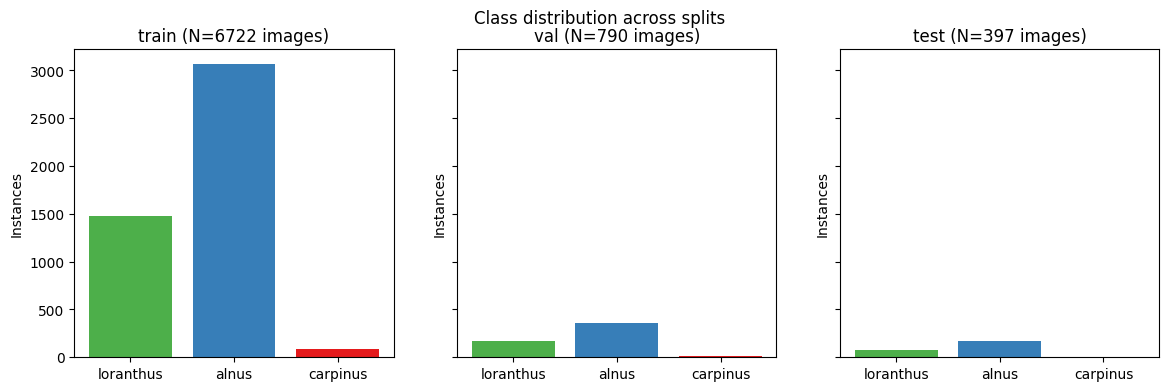

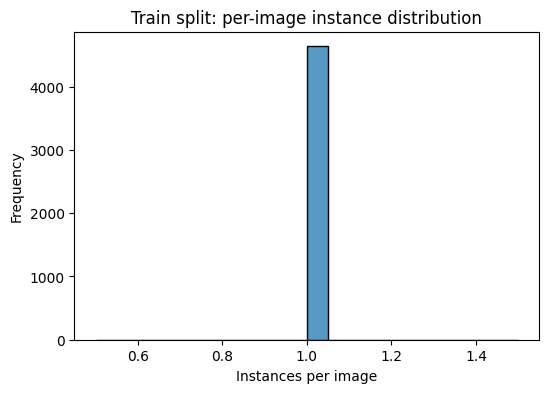

In [2]:
import json, collections
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 로드 (필요시 경로 바꿔줘)
files = {
    "train": "coco_thr001_top1_masks_train.json",
    "val": "coco_thr001_top1_masks_val.json",
    "test": "coco_thr001_top1_masks_test.json"
}

class_names = {1: "loranthus", 2: "alnus", 3: "carpinus"}  # category_id 매핑

def load_counts(path):
    with open(path, "r") as f:
        data = json.load(f)
    anns = data["annotations"]
    imgs = data["images"]

    # 클래스별 instance count
    per_class = collections.Counter([a["category_id"] for a in anns])

    # 이미지별 instance count
    per_img = collections.Counter([a["image_id"] for a in anns])

    return per_class, per_img, len(imgs)

# ---- Collect stats ----
stats = {}
for split, path in files.items():
    pc, pi, n_img = load_counts(path)
    stats[split] = {"per_class": pc, "per_img": pi, "n_img": n_img}

# ---- Plot: class distribution ----
fig, ax = plt.subplots(1, 3, figsize=(14,4), sharey=True)
for i, split in enumerate(["train", "val", "test"]):
    counts = [stats[split]["per_class"].get(cid,0) for cid in class_names]
    ax[i].bar(class_names.values(), counts, color=["#4daf4a","#377eb8","#e41a1c"])
    ax[i].set_title(f"{split} (N={stats[split]['n_img']} images)")
    ax[i].set_ylabel("Instances")
plt.suptitle("Class distribution across splits")
plt.show()

# ---- Plot: per-image histogram (example: train split) ----
train_counts = list(stats["train"]["per_img"].values())
plt.figure(figsize=(6,4))
sns.histplot(train_counts, bins=20, kde=False)
plt.xlabel("Instances per image")
plt.ylabel("Frequency")
plt.title("Train split: per-image instance distribution")
plt.show()

In [1]:
# =========================
# 0) Install & Imports
# =========================
!pip -q install -U 'torch>=2.2' 'torchvision>=0.17' --index-url https://download.pytorch.org/whl/cu121
!pip -q install -U opencv-python pycocotools
# Detectron2 prebuilt for CUDA 12.1 (Colab 최신 이미지 기준)
!pip -q install 'git+https://github.com/facebookresearch/detectron2.git'

import os, json, glob, random, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.utils.visualizer import Visualizer, ColorMode

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 578.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00


In [11]:
# === Google Drive (이미지 원본만 드라이브에 있음) ===
from google.colab import drive
drive.mount('/content/drive')

# === 로컬 업로드(코랩 런타임)에 둔 파일 경로 ===
MODEL = "/content/model_best.pth"  # 코랩에 올려둔 가중치
TRAIN_JSON = "/content/coco_thr001_top1_masks_train.json"
VAL_JSON   = "/content/coco_thr001_top1_masks_val.json"
TEST_JSON  = "/content/coco_thr001_top1_masks_test.json"

for p in [MODEL, TRAIN_JSON, VAL_JSON, TEST_JSON]:
    assert os.path.isfile(p), f"Missing local file: {p}"

print("✓ model/json files are present in /content")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ model/json files are present in /content


In [12]:
import json, os, shutil
from collections import defaultdict

def summarize_missing(path, max_show=5):
    with open(path, "r") as f:
        coco = json.load(f)
    im_by_id = {im["id"]: im for im in coco["images"]}
    miss = []
    for im in coco["images"]:
        if not os.path.isfile(im["file_name"]):
            miss.append(im["file_name"])
    print(f"[{os.path.basename(path)}] missing images: {len(miss)}")
    for s in miss[:max_show]:
        print("  -", s)
    return miss

def sanitize_coco(path, out_path=None):
    """
    file_name 경로에 실제 파일이 없는 이미지/주석을 제거한 깨끗한 COCO JSON 생성.
    """
    with open(path, "r") as f:
        coco = json.load(f)

    exist_ids = set()
    for im in coco["images"]:
        if os.path.isfile(im["file_name"]):
            exist_ids.add(im["id"])

    if out_path is None:
        root, ext = os.path.splitext(path)
        out_path = root + "_sanitized" + ext

    new_images = [im for im in coco["images"] if im["id"] in exist_ids]
    new_anns   = [a for a in coco["annotations"] if a["image_id"] in exist_ids]
    new_coco = dict(coco)
    new_coco["images"] = new_images
    new_coco["annotations"] = new_anns

    with open(out_path, "w") as f:
        json.dump(new_coco, f)
    print(f"→ wrote sanitized: {out_path} (images {len(new_images)}, anns {len(new_anns)})")
    return out_path

# 누락 요약(필요하면 보고)
_ = summarize_missing(TRAIN_JSON)
_ = summarize_missing(VAL_JSON)
_ = summarize_missing(TEST_JSON)

# 누락이 하나라도 있으면 자동 정리 실행
def maybe_sanitize(p):
    miss = summarize_missing(p)
    if len(miss) == 0:
        print("  no sanitize needed.")
        return p
    else:
        return sanitize_coco(p)

TRAIN_JSON_USE = maybe_sanitize(TRAIN_JSON)
VAL_JSON_USE   = maybe_sanitize(VAL_JSON)
TEST_JSON_USE  = maybe_sanitize(TEST_JSON)

[coco_thr001_top1_masks_train.json] missing images: 0
[coco_thr001_top1_masks_val.json] missing images: 0
[coco_thr001_top1_masks_test.json] missing images: 0
[coco_thr001_top1_masks_train.json] missing images: 0
  no sanitize needed.
[coco_thr001_top1_masks_val.json] missing images: 0
  no sanitize needed.
[coco_thr001_top1_masks_test.json] missing images: 0
  no sanitize needed.


In [13]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# 중복 등록 방지
for name in ["pollen_train","pollen_val","pollen_test"]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

# JSON의 file_name이 절대경로(드라이브)라서 image_root="/"로 등록 가능
register_coco_instances("pollen_train", {}, TRAIN_JSON_USE, "/")
register_coco_instances("pollen_val",   {}, VAL_JSON_USE,   "/")
register_coco_instances("pollen_test",  {}, TEST_JSON_USE,  "/")

print("Registered:", DatasetCatalog.list())

Registered: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'cityscapes_fine_sem_seg_trai

In [16]:
import json, os, datetime

def sanitise_coco(in_path, out_path=None):
    with open(in_path, "r") as f:
        data = json.load(f)

    changed = False
    if "info" not in data:
        data["info"] = {
            "description": "Pseudo-labeled pollen masks (thr=0.01, top-1 per image)",
            "version": "1.0",
            "year": 2025,
            "contributor": "auto",
            "date_created": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        }
        changed = True
    if "licenses" not in data:
        data["licenses"] = []
        changed = True

    out_path = out_path or in_path.replace(".json", "_sanitized.json")
    if changed:
        with open(out_path, "w") as f:
            json.dump(data, f)
    else:
        # 변경 필요 없으면 원본을 그대로 복사 저장(파일명 통일 목적)
        if in_path != out_path:
            with open(out_path, "w") as f:
                json.dump(data, f)
    return out_path

VAL_IN  = "/content/coco_thr001_top1_masks_val.json"
TEST_IN = "/content/coco_thr001_top1_masks_test.json"
TRAIN_IN= "/content/coco_thr001_top1_masks_train.json"

VAL_JSON  = sanitise_coco(VAL_IN)
TEST_JSON = sanitise_coco(TEST_IN)
TRAIN_JSON= sanitise_coco(TRAIN_IN)

print("Sanitized files:")
print("  train ->", TRAIN_JSON)
print("  val   ->", VAL_JSON)
print("  test  ->", TEST_JSON)

Sanitized files:
  train -> /content/coco_thr001_top1_masks_train_sanitized.json
  val   -> /content/coco_thr001_top1_masks_val_sanitized.json
  test  -> /content/coco_thr001_top1_masks_test_sanitized.json


In [17]:
import os, json, torch, glob
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import GeneralizedRCNNWithTTA

# --- COCO 등록(중복 제거 후) ---
for name in ["pollen_train","pollen_val","pollen_test"]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

register_coco_instances("pollen_train", {}, TRAIN_JSON, "/")
register_coco_instances("pollen_val",   {}, VAL_JSON,   "/")
register_coco_instances("pollen_test",  {}, TEST_JSON,  "/")

print("Registered:", DatasetCatalog.list())

# --- cfg & 모델 세팅 (학습은 안 하고, 평가만) ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.MASK_ON = True
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 1333
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# model_best.pth를 Colab 현재 작업 디렉토리에 업로드해놨다고 했으니:
cfg.MODEL.WEIGHTS = "/content/model_best.pth"   # 필요시 경로 확인
assert os.path.isfile(cfg.MODEL.WEIGHTS), "model_best.pth 경로를 확인하세요."

# 로드
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

# --- 평가 함수 ---
def eval_split(dataset_name, tta=False, outdir=None):
    if tta:
        model_ = GeneralizedRCNNWithTTA(cfg, model)
    else:
        model_ = model
    outdir = outdir or f"./eval_{dataset_name}{'_tta' if tta else ''}"
    os.makedirs(outdir, exist_ok=True)
    evaluator = COCOEvaluator(dataset_name, output_dir=outdir, tasks=("bbox","segm"))
    loader = build_detection_test_loader(cfg, dataset_name)
    print(f"== {dataset_name} :: {'TTA' if tta else 'no-TTA'} ==")
    res = inference_on_dataset(model_, loader, evaluator)
    print(res)
    return res

# --- 실제 평가 실행 ---
val_no   = eval_split("pollen_val",  tta=False)
test_no  = eval_split("pollen_test", tta=False)
val_tta  = eval_split("pollen_val",  tta=True)
test_tta = eval_split("pollen_test", tta=True)

# --- 요약 테이블 (csv 저장) ---
from collections import OrderedDict
import pandas as pd

def flatten_metrics(d):
    out = OrderedDict()
    for head in ["segm","bbox"]:
        if head in d:
            sec = d[head]
            for k,v in sec.items():
                out[f"{head}/{k}"] = v
    return out

rows = []
rows.append(("val_noTTA",  flatten_metrics(val_no)))
rows.append(("test_noTTA", flatten_metrics(test_no)))
rows.append(("val_TTA",    flatten_metrics(val_tta)))
rows.append(("test_TTA",   flatten_metrics(test_tta)))

keys = sorted(set().union(*[set(r[1].keys()) for r in rows]))
table = []
for name, dd in rows:
    row = {"split": name}
    row.update({k: dd.get(k, None) for k in keys})
    table.append(row)

df = pd.DataFrame(table).set_index("split").round(3)
# Δ행 추가
for head in ["segm","bbox"]:
    col = f"{head}/AP"
    if col in df.columns:
        if {"val_noTTA","val_TTA"}.issubset(df.index):
            df.loc["val_Δ(TTA-noTTA)", col] = df.loc["val_TTA", col] - df.loc["val_noTTA", col]
        if {"test_noTTA","test_TTA"}.issubset(df.index):
            df.loc["test_Δ(TTA-noTTA)", col] = df.loc["test_TTA", col] - df.loc["test_noTTA", col]

display(df)
df.to_csv("/content/eval_summary.csv")
print("Saved:", "/content/eval_summary.csv")

Registered: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'cityscapes_fine_sem_seg_trai

,bbox/AP,bbox/AP-alnus,bbox/AP-carpinus,bbox/AP-loranthus,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,segm/AP,segm/AP-alnus,segm/AP-carpinus,segm/AP-loranthus,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs
split,,,,,,,,,,,,,,,,,,
val_noTTA,59.259,75.240,47.976,54.561,73.971,69.075,60.191,47.390,27.921,62.745,79.875,52.032,56.327,73.751,68.724,63.733,57.283,38.727
test_noTTA,60.856,77.064,51.271,54.232,74.852,70.807,61.174,29.898,NaN,64.840,81.904,54.454,58.162,75.046,71.663,65.282,29.071,NaN
val_TTA,57.185,72.570,46.316,52.669,71.429,66.810,58.027,46.389,33.795,60.511,77.941,49.303,54.289,71.529,66.131,61.325,60.248,33.795
test_TTA,59.106,73.530,51.003,52.787,72.789,68.023,59.379,44.444,NaN,61.763,78.782,50.007,56.498,72.789,69.867,61.992,33.751,NaN
val_Δ(TTA-noTTA),-2.074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_Δ(TTA-noTTA),-1.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved: /content/eval_summary.csv


In [18]:
import json
VAL_JSON_USE = "coco_thr001_top1_masks_val_sanitized.json"  # 네가 실제 등록에 쓴 파일 경로
with open(VAL_JSON_USE,"r") as f:
    data = json.load(f)
print("VAL images =", len(data["images"]))         # ← 여기 숫자가 inference 이미지 수

VAL images = 790


In [19]:
from detectron2.data import DatasetCatalog
len(DatasetCatalog.get("pollen_val"))              # ← 평가에 쓰이는 실제 샘플 수

[08/30 17:24:15 d2.data.datasets.coco]: Loaded 790 images in COCO format from /content/coco_thr001_top1_masks_val_sanitized.json


790

In [20]:
import os, random, json, numpy as np, cv2, matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from pycocotools import mask as maskUtils

os.makedirs("/content/figures", exist_ok=True)

meta_val  = MetadataCatalog.get("pollen_val")
meta_test = MetadataCatalog.get("pollen_test")

# 이미 위에서 cfg, model_best.pth 로드 했다고 가정 (cfg.MODEL.WEIGHTS=/content/model_best.pth)
cfg_pred = cfg.clone()
cfg_pred.MODEL.WEIGHTS = "/content/model_best.pth"
cfg_pred.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg_pred)

val_dicts  = DatasetCatalog.get("pollen_val")
test_dicts = DatasetCatalog.get("pollen_test")

[08/30 17:24:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/model_best.pth ...
[08/30 17:24:18 d2.data.datasets.coco]: Loaded 790 images in COCO format from /content/coco_thr001_top1_masks_val_sanitized.json
[08/30 17:24:18 d2.data.datasets.coco]: Loaded 397 images in COCO format from /content/coco_thr001_top1_masks_test_sanitized.json


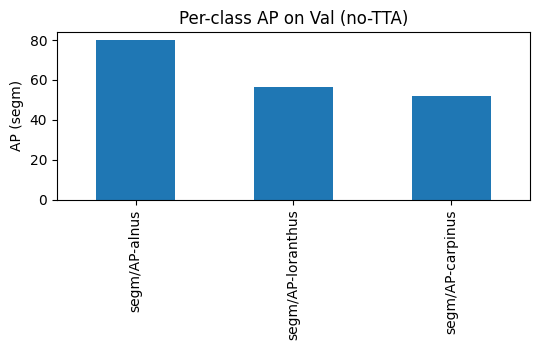

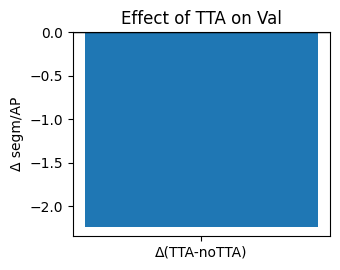

In [21]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("/content/eval_summary.csv").set_index("split")
# segm/AP-<class> 만 골라서 시각화 (val_noTTA 기준)
cols = [c for c in df.columns if c.startswith("segm/AP-")]
pc = df.loc["val_noTTA", cols].dropna()
plt.figure(figsize=(5.5,3.6))
pc.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("AP (segm)")
plt.title("Per-class AP on Val (no-TTA)")
plt.tight_layout()
plt.savefig("/content/figures/segm_per_class_AP_val_noTTA.png", dpi=300)
plt.show()

# TTA 델타 (segm/AP)
if {"val_noTTA","val_TTA"}.issubset(df.index):
    delta = df.loc["val_TTA","segm/AP"] - df.loc["val_noTTA","segm/AP"]
    plt.figure(figsize=(3.5,2.8))
    plt.bar(["Δ(TTA-noTTA)"], [delta])
    plt.axhline(0, color="k", lw=1)
    plt.ylabel("Δ segm/AP")
    plt.title("Effect of TTA on Val")
    plt.tight_layout()
    plt.savefig("/content/figures/tta_delta_val.png", dpi=300)
    plt.show()

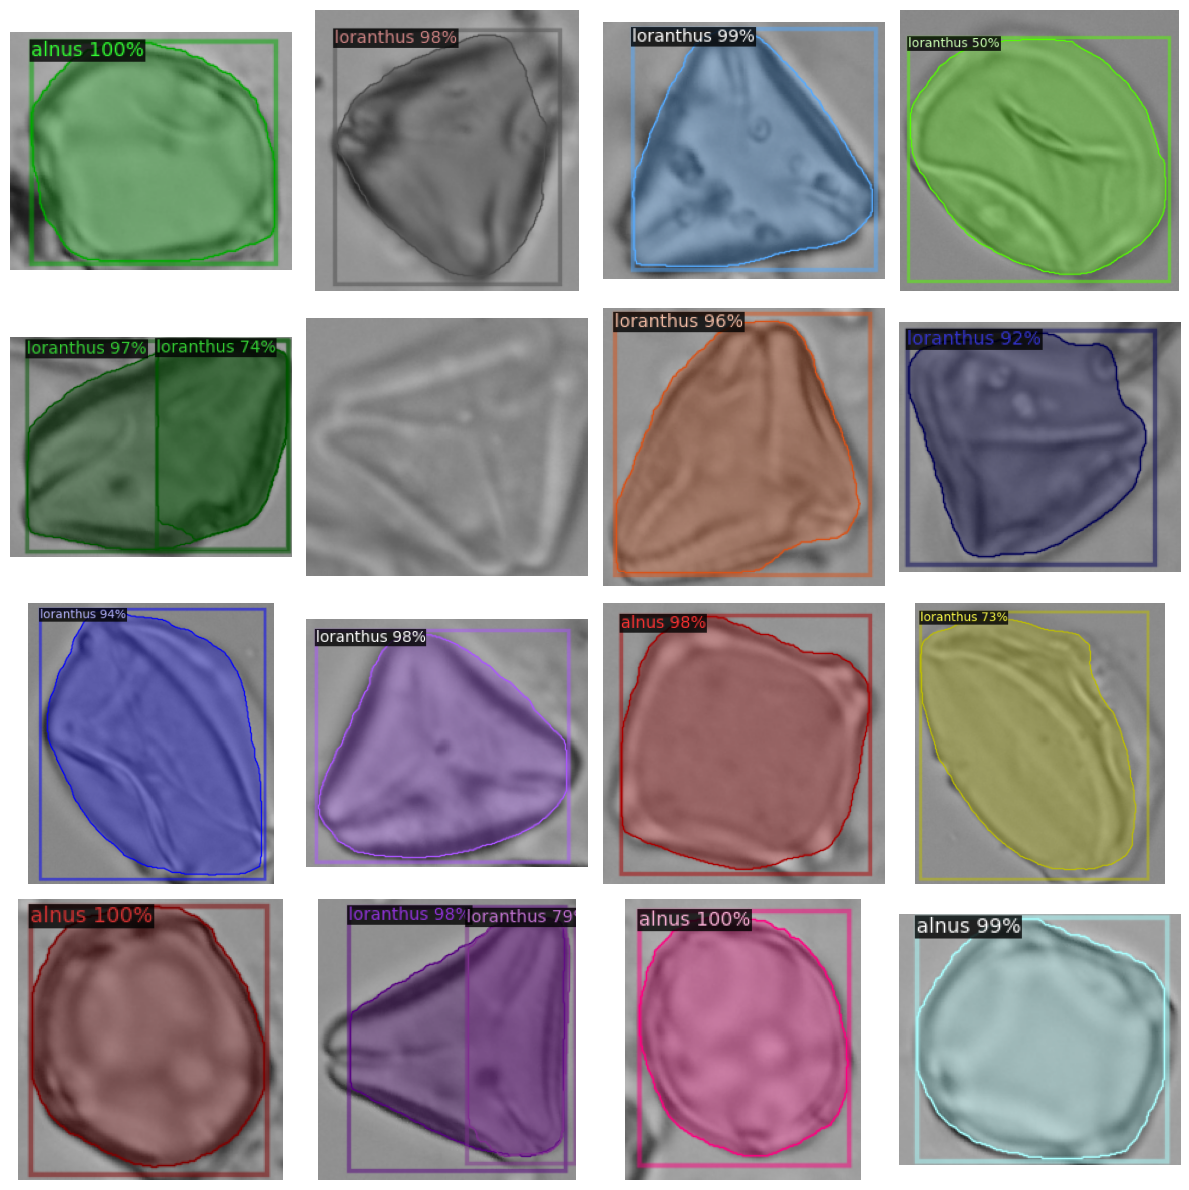

In [22]:
def draw_grid(dicts, K=16, out="/content/figures/val_overlay_grid.png", seed=0):
    rng = random.Random(seed)
    sel = rng.sample(dicts, k=min(K, len(dicts)))
    ncols=4; nrows=int(np.ceil(len(sel)/ncols))
    plt.figure(figsize=(ncols*3, nrows*3))
    for i,d in enumerate(sel):
        img = cv2.imread(d["file_name"])
        outp = predictor(img)
        v = Visualizer(img[:, :, ::-1], metadata=meta_val, scale=1.0,
                       instance_mode=ColorMode.IMAGE_BW)
        v = v.draw_instance_predictions(outp["instances"].to("cpu"))
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(v.get_image()); ax.axis("off")
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.show()

draw_grid(val_dicts, K=16, out="/content/figures/val_overlay_grid.png", seed=42)

Collected FPs: 416, FNs: 261, TPs: 4


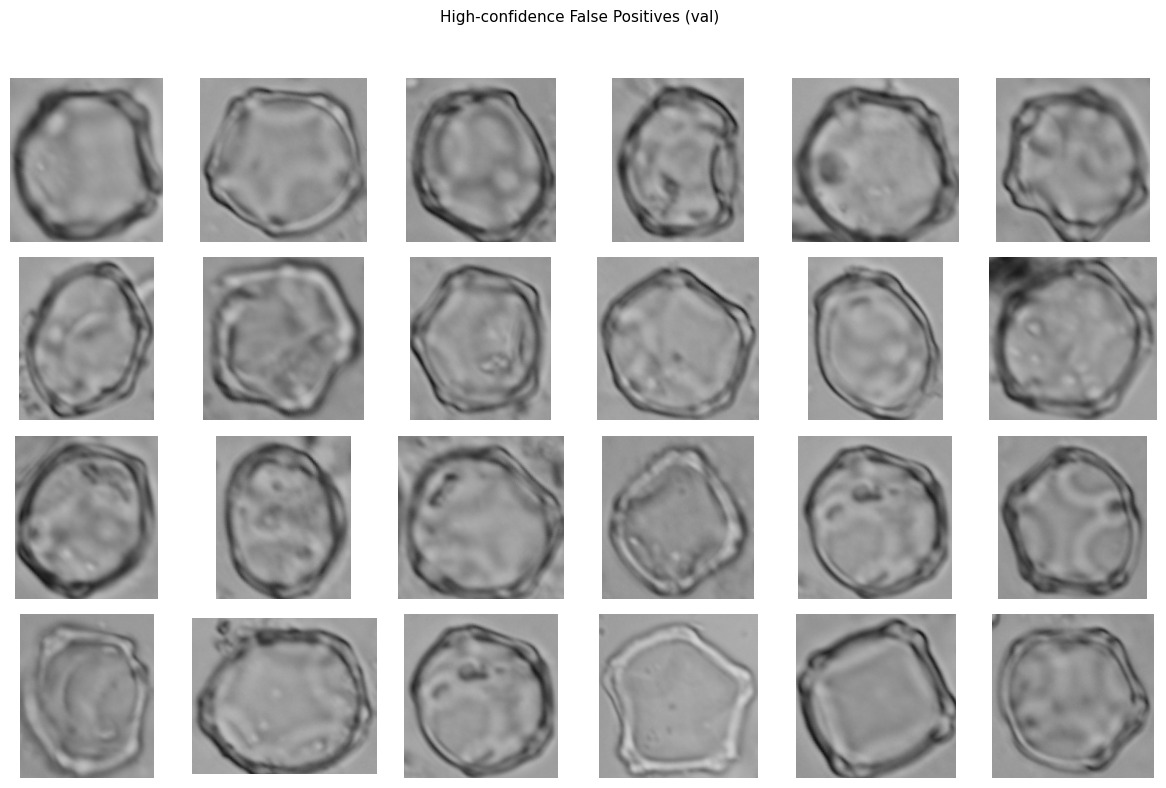

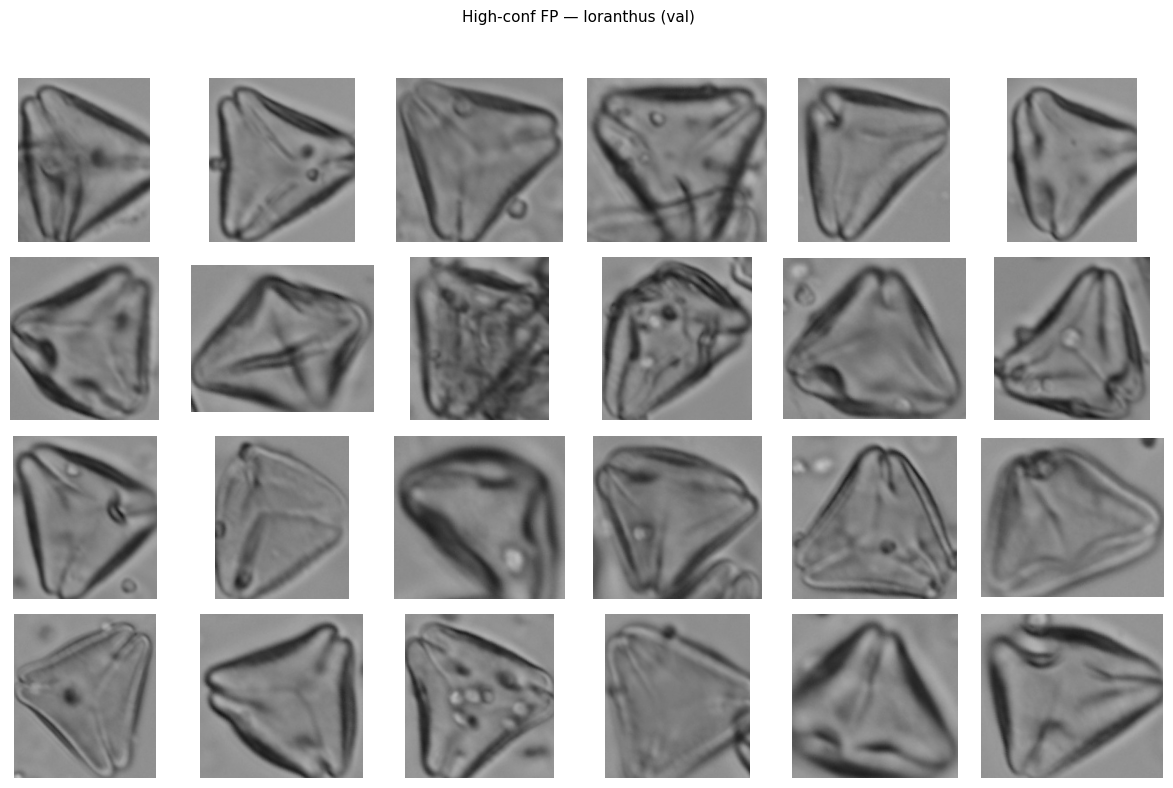

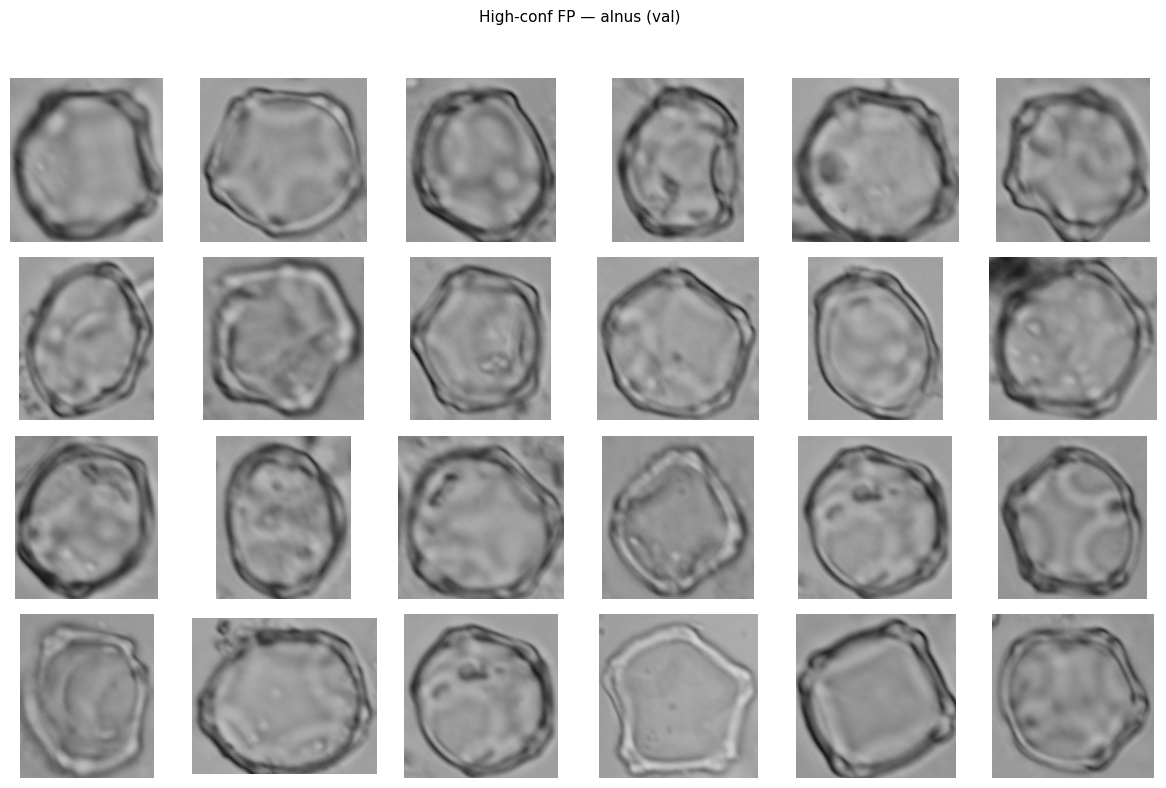

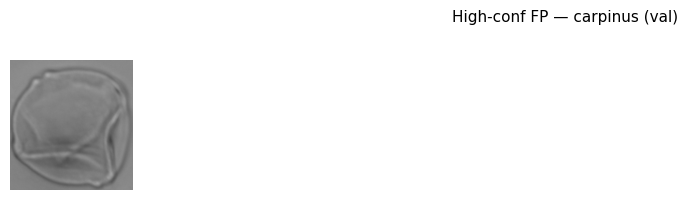

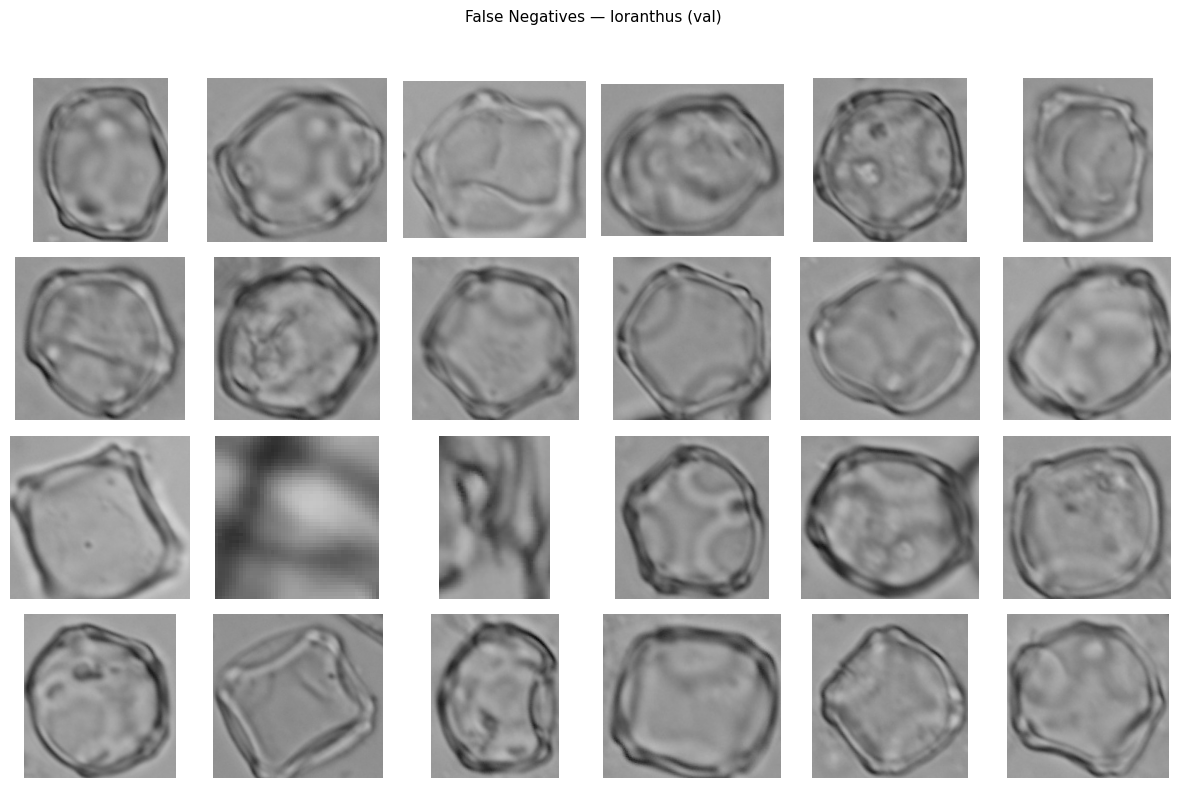

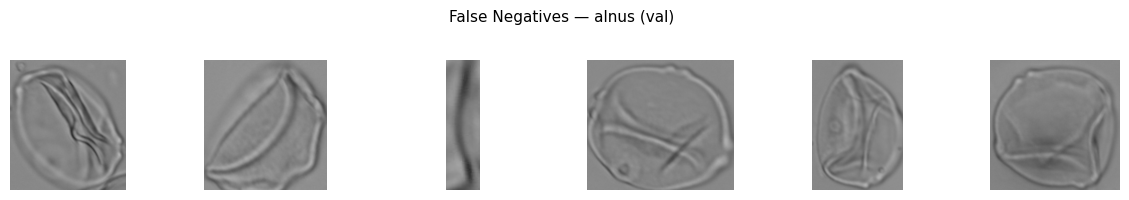

In [23]:
import math

CAT_ID_TO_NAME = {k:v for k,v in enumerate(["loranthus","alnus","carpinus"], start=1)}
NAME_TO_CAT_ID = {v:k for k,v in CAT_ID_TO_NAME.items()}

def rle_to_mask(seg, h, w):
    # seg: COCO RLE(dict) or polygon(list)
    if isinstance(seg, dict) and "counts" in seg:
        return maskUtils.decode(seg).astype(np.uint8)  # (h,w,1)
    # 폴리곤이면 합성
    if isinstance(seg, list):
        rles = maskUtils.frPyObjects(seg, h, w)
        rle  = maskUtils.merge(rles)
        return maskUtils.decode(rle).astype(np.uint8)
    return None

def instances_to_masks(instances, h, w):
    # pred_masks: (N, H, W) bool
    pm = instances.pred_masks.cpu().numpy().astype(np.uint8)
    cls = instances.pred_classes.cpu().numpy()   # 0..(num-1)
    sc  = instances.scores.cpu().numpy()
    return pm, cls, sc

def compute_iou(m1, m2):
    inter = (m1 & m2).sum()
    union = (m1 | m2).sum()
    return inter / union if union > 0 else 0.0

def mine_errors(dicts, max_images=400, iou_thr=0.5, seed=0):
    rng = random.Random(seed)
    picks = rng.sample(dicts, k=min(max_images, len(dicts)))

    FPs = []  # (score, file, crop_img)
    FNs = []  # (file, crop_img, gt_cls)
    TPs = []  # optional, for sanity

    for d in picks:
        img = cv2.imread(d["file_name"])
        if img is None:
            continue
        h,w = img.shape[:2]
        outs = predictor(img)
        inst = outs["instances"].to("cpu")
        pm, cls, sc = instances_to_masks(inst, h, w)

        # GT 마스크들
        gts = []
        for a in d["annotations"]:
            m = rle_to_mask(a["segmentation"], h, w)
            if m is None:
                continue
            gts.append({"mask": m[:,:,0] if m.ndim==3 else m, "cid": a["category_id"], "used": False})

        # 예측별로 매칭 (탑-IoU)
        for i in range(pm.shape[0]):
            pred_m = pm[i]
            pred_c = int(cls[i]) + 1  # detectron2 classes 0-based -> our CAT ID 1-based
            score  = float(sc[i])

            best_iou, best_j = 0.0, -1
            for j,g in enumerate(gts):
                if g["used"] or g["cid"] != pred_c:
                    continue
                iou = compute_iou(pred_m, g["mask"])
                if iou > best_iou:
                    best_iou, best_j = iou, j

            if best_iou >= iou_thr and best_j >= 0:
                gts[best_j]["used"] = True
                TPs.append((score, d["file_name"], pred_c))
            else:
                # FP 후보 저장 (컷아웃)
                ys, xs = np.where(pred_m > 0)
                if len(xs) and len(ys):
                    x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
                    crop = img[max(0,y1-8):min(h,y2+8), max(0,x1-8):min(w,x2+8)]
                    FPs.append((score, d["file_name"], pred_c, crop))

        # 매칭 안 된 GT = FN
        for g in gts:
            if not g["used"]:
                ys, xs = np.where(g["mask"] > 0)
                if len(xs) and len(ys):
                    x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
                    crop = img[max(0,y1-8):min(h,y2+8), max(0,x1-8):min(w,x2+8)]
                    FNs.append((d["file_name"], g["cid"], crop))

    return FPs, FNs, TPs

FPs, FNs, TPs = mine_errors(val_dicts, max_images=400, iou_thr=0.5, seed=13)
print(f"Collected FPs: {len(FPs)}, FNs: {len(FNs)}, TPs: {len(TPs)}")

def grid_gallery(items, title, out, nmax=24, ncols=6):
    items = items[:nmax]
    n = len(items)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(ncols*2, nrows*2))
    for i, it in enumerate(items):
        crop = it[-1]
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)); ax.axis("off")
    plt.suptitle(title, fontsize=11)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(out, dpi=300); plt.show()

# 고확신 FP 상위 (전체 + 클래스별)
FPs_sorted = sorted(FPs, key=lambda x: -x[0])
grid_gallery(FPs_sorted, "High-confidence False Positives (val)", "/content/figures/val_high_conf_FP.png")

for cname, cid in NAME_TO_CAT_ID.items():
    fpc = [x for x in FPs_sorted if x[2]==cid]
    if len(fpc):
        grid_gallery(fpc, f"High-conf FP — {cname} (val)", f"/content/figures/val_high_conf_FP_{cname}.png")

# FN (클래스별)
for cname, cid in NAME_TO_CAT_ID.items():
    fnc = [x for x in FNs if x[1]==cid]
    if len(fnc):
        grid_gallery(fnc, f"False Negatives — {cname} (val)", f"/content/figures/val_FN_{cname}.png")

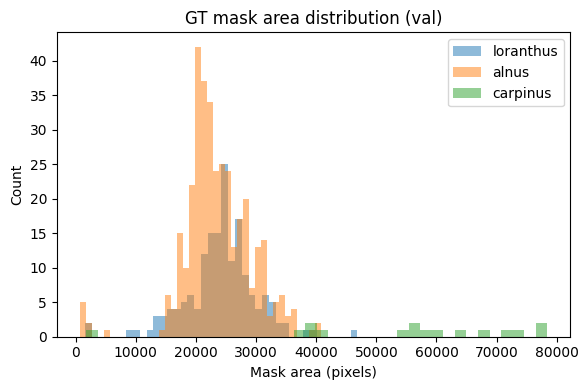

In [24]:
import json, numpy as np, matplotlib.pyplot as plt

def gt_area_hist(json_path, out_png):
    with open(json_path, "r") as f:
        coco = json.load(f)
    id2img = {im["id"]: im for im in coco["images"]}
    areas = {1:[], 2:[], 3:[]}
    for a in coco["annotations"]:
        areas[a["category_id"]].append(a["area"])
    plt.figure(figsize=(6,4))
    for cid, arr in areas.items():
        if len(arr):
            plt.hist(arr, bins=40, alpha=0.5, label=CAT_ID_TO_NAME[cid])
    plt.xlabel("Mask area (pixels)"); plt.ylabel("Count"); plt.legend()
    plt.title("GT mask area distribution (val)")
    plt.tight_layout(); plt.savefig(out_png, dpi=300); plt.show()

gt_area_hist("/content/coco_thr001_top1_masks_val_sanitized.json", "/content/figures/val_gt_mask_area_hist.png")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.06s).


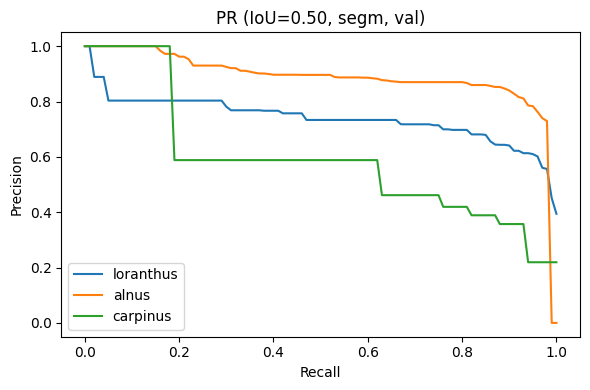

In [25]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json, numpy as np, matplotlib.pyplot as plt, os

# Detectron2가 저장한 예측 파일 사용
res_json = "./eval_pollen_val/coco_instances_results.json"
gt_json  = "/content/coco_thr001_top1_masks_val_sanitized.json"

coco_gt  = COCO(gt_json)
coco_dt  = coco_gt.loadRes(res_json)

e = COCOeval(coco_gt, coco_dt, iouType="segm")
e.params.useCats = 1
e.evaluate(); e.accumulate()

# e.eval['precision']: [TxRxKxAxM] (T=IoU thresholds, R=recall points, K=classes)
prec = e.eval['precision']  # shape (T, R, K, A, M)
iou_thrs = e.params.iouThrs
rec_thrs = e.params.recThrs
K = prec.shape[2]

# mAP에서 일반적으로 쓰는 IoU=0.50, 0.75, 혹은 mean. 여기선 IoU=0.50 커브 하나 예로.
t50 = np.where(np.isclose(iou_thrs, 0.5))[0][0]

plt.figure(figsize=(6,4))
for k in range(K):
    p = prec[t50, :, k, 0, -1]  # area=all, maxDets=last
    p = np.where(p<0, np.nan, p)
    plt.plot(rec_thrs, p, label=CAT_ID_TO_NAME[k+1])
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (IoU=0.50, segm, val)")
plt.legend(); plt.tight_layout()
plt.savefig("/content/figures/pr_curves_val_iou50.png", dpi=300)
plt.show()

In [26]:
import zipfile, os

fig_dir = "/content/figures"   # 시각화 파일들이 저장된 폴더
zip_path = "/content/figures_student_model.zip"

with zipfile.ZipFile(zip_path, "w") as zf:
    for root, _, files in os.walk(fig_dir):
        for f in files:
            file_path = os.path.join(root, f)
            arcname = os.path.relpath(file_path, fig_dir)  # 폴더 구조 유지
            zf.write(file_path, arcname)

print("Saved:", zip_path)

Saved: /content/figures_student_model.zip


In [27]:
import pandas as pd

# CSV 다시 로드
df = pd.read_csv("/content/eval_summary.csv", index_col=0)

# 논문에 필요한 핵심 컬럼만 추출
cols = [
    "segm/AP", "segm/AP50", "segm/AP75",
    "segm/AP-alnus", "segm/AP-loranthus", "segm/AP-carpinus"
]
core_table = df[cols].round(1)  # 소수점 1자리 정리

print(core_table)

# 저장
core_table.to_csv("/content/eval_summary_core.csv")
print("Saved:", "/content/eval_summary_core.csv")

                   segm/AP  segm/AP50  segm/AP75  segm/AP-alnus  \
split                                                             
val_noTTA             62.7       73.8       68.7           79.9   
test_noTTA            64.8       75.0       71.7           81.9   
val_TTA               60.5       71.5       66.1           77.9   
test_TTA              61.8       72.8       69.9           78.8   
val_Δ(TTA-noTTA)      -2.2        NaN        NaN            NaN   
test_Δ(TTA-noTTA)     -3.1        NaN        NaN            NaN   

                   segm/AP-loranthus  segm/AP-carpinus  
split                                                   
val_noTTA                       56.3              52.0  
test_noTTA                      58.2              54.5  
val_TTA                         54.3              49.3  
test_TTA                        56.5              50.0  
val_Δ(TTA-noTTA)                 NaN               NaN  
test_Δ(TTA-noTTA)                NaN               NaN  
Saved: 

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.19s).


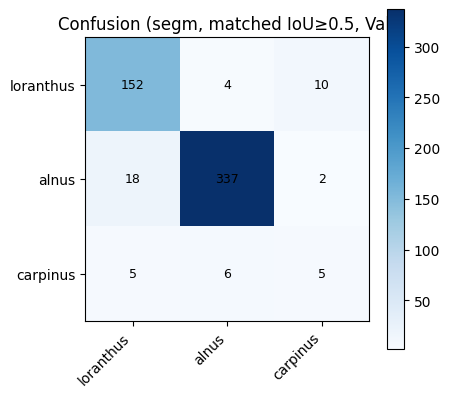

In [31]:
from pycocotools import mask as maskUtils
import numpy as np
import itertools

def segm_confusion_matrix(coco_gt, coco_dt, iou_thr=0.5):
    e = COCOeval(coco_gt, coco_dt, iouType="segm")
    e.params.useCats = 1
    e.params.iouThrs = np.array([iou_thr])
    e.evaluate()  # we will do our own greedy match per image

    catIds = coco_gt.getCatIds()
    imgIds = e.params.imgIds
    cm = np.zeros((len(catIds), len(catIds)), dtype=int)

    for img_id in imgIds:
        gts = coco_gt.loadAnns(coco_gt.getAnnIds(img_id, catIds=catIds))
        dts = coco_dt.loadAnns(coco_dt.getAnnIds(img_id))
        used_dt = set()

        for gt in gts:
            gt_rle = coco_gt.annToRLE(gt)
            best_iou, best_j = 0.0, -1
            for j, dt in enumerate(dts):
                if j in used_dt or dt['category_id'] is None:
                    continue
                dt_rle = coco_gt.annToRLE(dt)
                iou = maskUtils.iou([gt_rle], [dt_rle], [0])[0][0]
                if iou > best_iou:
                    best_iou, best_j = iou, j
            if best_iou >= iou_thr and best_j >= 0:
                gi = catIds.index(gt['category_id'])
                pi = catIds.index(dts[best_j]['category_id'])
                cm[gi, pi] += 1
                used_dt.add(best_j)

    names = [coco_gt.loadCats([cid])[0]['name'] for cid in catIds]
    plt.figure(figsize=(4.6,4.2))
    plt.imshow(cm, cmap="Blues"); plt.colorbar()
    plt.xticks(range(len(names)), names, rotation=45, ha="right")
    plt.yticks(range(len(names)), names)
    plt.title("Confusion (segm, matched IoU≥0.5, Val)")
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        v = cm[i,j]
        if v>0: plt.text(j,i,str(v),ha='center',va='center',fontsize=9)
    plt.tight_layout(); plt.savefig("/content/figures/segm_confusion_val.png", dpi=300); plt.show()

# --- 재실행 ---
segm_confusion_matrix(coco_gt, coco_dt, iou_thr=0.5)